# Class Function bender class with multiple methods defined 

In [342]:
import pandas as pd
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn import preprocessing
from scipy import stats
import numpy as np
import matplotlib.pyplot as plt  # To visualize
import os
import glob

In [343]:
class bender_class:  
    
    def __init__(self, data):
        
        # Ensure data is a pandas DataFrame
        if not isinstance(data, pd.DataFrame):
            raise TypeError("Expected 'data' to be a pandas DataFrame.")
        
        self.data = data #dataframe containing data from all csv files analyzed -> m rows by 4 columns
        self.acc = None  #accuracy from quadratic curve fitting class method:  quadriatic_fit(self)
        self.model = None  # To store the trained model
        self.poly_features = None  # To store polynomial features
        
    def __str__(self):
        return (f"Bender Class: \n"
            f"  Number of data points: {self.data.shape[0] if self.data is not None else 0}\n"
            f"  Number of features: {self.data.shape[1] if self.data is not None else 0}\n"
            f"  Current Accuracy: {self.acc:.2f}% if self.acc is not None else 'N/A'\n")
    
    def __repr__(self):
        return (f"Bender_class(data={self.data.head() if self.data is not None else 'None'}, "
            f"acc={self.acc}, "
            f"model={self.model.__class__.__name__ if self.model else 'None'}, "
            f"poly_features={self.poly_features.__class__.__name__ if self.poly_features else 'None'})")
    
    def read_data(self, path):
        """
        class method to extract all csv files in path and concatenate data in pandas dataframe
        class method also normalizes ADC around 0 and converts rotary encoder angle to deg, then 
        shifts angles to start at 0 deg
        """
        
        # use glob to get all the csv files
        # in the folder
        csv_files = glob.glob(path)
        
        if not isinstance(path, str):
            raise TypeError("Expected 'path' to be a string.")
        if not csv_files:
            raise FileNotFoundError(f"No CSV files found in the specified path: {path}")
        
        # Initialize an empty list to hold the DataFrames
        dataframes = []

        # loop over the list of csv files
        for f in csv_files:
                  
            try:
                # Read the csv file
                df = pd.read_csv(f)
            except Exception as e:
                print(f"Error reading {f}: {e}")
                continue
            
            # Check if the DataFrame has exactly 4 columns
            if df.shape[1] != 4:
                raise ValueError(f"Error: The file {f} does not contain exactly 4 columns. It has {df.shape[1]} columns.")
            
            # Remove rows where the first column equals 100
            df = df[df.iloc[:, 0] != 100]
            # center ADC values around 0 (normalize ADC values)
            df.iloc[:, 2] = (df.iloc[:, 2] - df.iloc[1, 2]) / df.iloc[1, 2]
            
            #Changes made 10/14/2024:  Normalization of data from 0 -> 1:  
            #https://scikit-learn.org/1.5/modules/generated/sklearn.preprocessing.MinMaxScaler.html
            
            y = df.iloc[:, 2].values #returns a numpy array
            y = y.reshape(-1, 1)
            # Initialize the MinMaxScaler
            min_max_scaler = preprocessing.MinMaxScaler()
            # Fit and transform the data
            y_scaled = min_max_scaler.fit_transform(y)
            # Update the DataFrame with scaled values
            df.iloc[:, 2] = y_scaled.flatten()  # Flatten back to 1D for assignment
                
            #convert rotary encoder to angle (deg) -> ADC is arduino Uno 10 bit
            df.iloc[:, 3] = df.iloc[:, 3] * 320 / 1024
            #shift rotary encoder angles to start tests at 0 deg
            df.iloc[:, 3] = df.iloc[:, 3] - df.iloc[1, 3]
            # Append the DataFrame to the list
            dataframes.append(df)
            
         # Concatenate all DataFrames in the list into a single DataFrame
        self.data = pd.concat(dataframes, ignore_index=True)
                      
        return self.data
    
    def read_data_2(self, path):
        """
        Class method used for wheatstone bridge data.  Method extracts all csv files in path and concatenate data in pandas dataframe.
        Normalizes ADC around 0, converts rotary encoder angle to degrees, and adjusts ΔR / Rₒ.  Data also drops NaN rows and has the potential to get rid of 
        very extreme data points (looks like a handful in each dataset)!
        """

        # Use glob to get all the csv files in the folder
        csv_files = glob.glob(path)
        print(f"Found {len(csv_files)} CSV files.")  # Debug statement
    
        # Initialize an empty list to hold the DataFrames
        dataframes = []

        # Loop over the list of csv files
        for f in csv_files:
            df = pd.read_csv(f)
        
            # Remove rows where the first column equals 100
            df = df[df.iloc[:, 0] != 100]
                    
            # Remove rows with any NaN values
            df = df.dropna()
        
            # center ADC values around 0 (normalize ADC values)
            #df.iloc[:, 2] = (df.iloc[:, 2] - df.iloc[15, 2]) / df.iloc[1, 2]
        
             # Ensure slopes are positive
            df.iloc[:, 2] = df.iloc[:, 2].abs()
            
            #Changes made 10/14/2024:  Normalization of data from 0 -> 1:  
            #https://scikit-learn.org/1.5/modules/generated/sklearn.preprocessing.MinMaxScaler.html
            
            y = df.iloc[:, 2].values #returns a numpy array
            y = y.reshape(-1, 1)
            # Initialize the MinMaxScaler
            min_max_scaler = preprocessing.MinMaxScaler()
            # Fit and transform the data
            y_scaled = min_max_scaler.fit_transform(y)
            # Update the DataFrame with scaled values
            df.iloc[:, 2] = y_scaled.flatten()  # Flatten back to 1D for assignment
                
        
            # Convert rotary encoder to angle (degrees) -> ADC is Arduino Uno 10 bit
            df.iloc[:, 3] = df.iloc[:, 3] * 320 / 1024
        
            # Shift rotary encoder angles to start tests at 0 degrees
            initial_angle = df.iloc[20, 3]  # Save initial angle for later adjustment
            df.iloc[:, 3] = df.iloc[:, 3] - initial_angle 
            
                 
            # Append the DataFrame to the list
            dataframes.append(df)

        # Concatenate all DataFrames in the list into a single DataFrame
        self.data = pd.concat(dataframes, ignore_index=True)

        return self.data
    
    def plot_data(self):
        """
        class method to plot normalized ADC values vs Rotary Encoder angles (blue dots) AND IMU angles (red dots)
        """
        if self.data is None:
            raise ValueError("Data not available. Please read the data first.")
        
        # Plotting Rotary Encoder data
        plt.plot(-1 * self.data.iloc[:, 3], self.data.iloc[:, 2], 'b', label='Rotary Encoder')  # Blue circles for Rotary Encoder
        
        # Plotting IMU data
        plt.plot(-1 * self.data.iloc[:, 1], self.data.iloc[:, 2], 'ro', label='IMU')  # Red circles for IMU

        # Setting labels
        plt.xlabel('Angle (deg)')
        plt.ylabel('MinMax(ADC)')

        # Adding legend
        plt.legend()

        # Setting x-axis limits
        #plt.xlim([0, 110])

        # Display the plot
        plt.show()
        return
    
    def quadratic_fit(self):
        """
        class method to fit rotary encoder data using quadratic fit and give r2 value of fit
        """
        
        if self.data is None:
            raise ValueError("Data not available. Please read the data first.")
    
        x = -1 * self.data.iloc[:, 3].values  # Rotary Encoder angles (inverted)
        y = self.data.iloc[:, 2].values        # ΔR / Rₒ values
        
        # Fit a quadratic polynomial to the data
        coefficients = np.polyfit(x, y, 2)  # 2 is the degree for quadratic
        polynomial = np.poly1d(coefficients)
        
        # Generate x values for plotting the fitted curve
        x_fit = np.linspace(np.min(x), np.max(x), 100)
        y_fit = polynomial(x_fit)

        # Calculate R² value
        y_pred = polynomial(x)  # Predicted values from the fit
        r2 = r2_score(y, y_pred)  # Calculate R²

        # Plot the original data
        plt.plot(x, y, 'bo', label='Rotary Encoder Data')  # Original data
        plt.plot(x_fit, y_fit, 'r-', label='Quadratic Fit')  # Fitted curve
        
        # Setting labels
        plt.xlabel('Angle (deg)')
        plt.ylabel('ΔR / Rₒ')
        
        # Adding legend
        plt.legend()
        
        # Display the plot with R² in the title
        plt.title(f'Quadratic Fit of ΔR / Rₒ vs Angle (R² = {r2:.2f})')
        plt.show()
        
    def train_test(self, deg_accuracy):
        """
        class method to determine how well a model that predicts angle based on normalized ADC value input up to +/- deg_accuracy 
        """
        
        if self.data is None:
            raise ValueError("Data not available. Please read the data first.")
            
               
        # Cross-validation (train: 80%, test: 20%)
        dataTrain, dataTest = train_test_split(self.data, test_size=0.2, random_state=None)

        # Fit a polynomial of degree 2 to the training data
        poly_features = PolynomialFeatures(degree=2)
        X_train = -1 * dataTrain.iloc[:, 2].values.reshape(-1, 1)  
        y_train = dataTrain.iloc[:, 3].values  
        X_train_poly = poly_features.fit_transform(X_train)

        self.model = LinearRegression()
        self.model.fit(X_train_poly, y_train)
        self.poly_features = poly_features  # Store the polynomial features

        # Predicting using the test set
        X_test = -1 * dataTest.iloc[:, 2].values.reshape(-1, 1)  
        X_test_poly = self.poly_features.transform(X_test)
        y_test = self.model.predict(X_test_poly)

        # Accuracy determined by finding the number of test data that predicts
        # actual angle correctly to within +/- deg_accuracy
        pos = np.sum(np.abs(y_test - dataTest.iloc[:, 3].values) < deg_accuracy)  
        total = len(dataTest)

        # Calculate accuracy
        self.acc = pos * 100 / total if total > 0 else 0  # Avoid division by zero
        
         # Optionally print the accuracy
        #print(f'Accuracy: {self.acc:.2f}%')
        
        return self.acc
    
    def predict_new_data(self, new_data_obj, deg_accuracy):
        """
        Uses the trained model to make predictions on new data from another bender_class object
        and calculates the accuracy of those predictions based on a specified degree of accuracy.

        :param new_data_obj: An instance of bender_class containing new data for predictions.
        :param deg_accuracy: The degree of accuracy within which the predictions are considered correct.
        :return: A float representing the accuracy of the predictions.
        """
        # Ensure that the model has been trained
        if self.model is None or self.poly_features is None:
            raise Exception("Model has not been trained yet. Please run the train_test method first.")
        
        
        # Retrieve new data
        new_data = new_data_obj.data

        # Prepare new data for prediction
        X_new = -1 * new_data.iloc[:, 2].values.reshape(-1, 1)  # Assuming the same structure
        X_new_poly = self.poly_features.transform(X_new)

        # Predict using the trained model
        y_pred_new = self.model.predict(X_new_poly)

        # Calculate accuracy based on the setpoint
        # Assuming the actual angles are in the fourth column of the new data
        actual_angles = new_data.iloc[:, 3].values
        pos = np.sum(np.abs(y_pred_new - actual_angles) < deg_accuracy)  # Count how many predictions are within the specified accuracy
        total = len(actual_angles)

        # Calculate accuracy
        accuracy = pos * 100 / total if total > 0 else 0  # Avoid division by zero

        # Optionally print the accuracy
        #print(f'Prediction Accuracy: {accuracy:.2f}%')

        # Create a DataFrame to hold the new data and the predictions
        results = pd.DataFrame(new_data)
        results['Predicted_Angle'] = y_pred_new  # Add predictions as a new column

        return accuracy, results
    
    
    
       
    

# Model Fitting

The following block of code creates an object g that reads four sets of CSV files (without reapplication), constructs a pandas DataFrame, and fits a second-order polynomial model using 80% of the data for training and 20% for testing (as defined in the train_test class method). This data split is performed randomly. After fitting the model, the code plots the model's accuracy over 100 iterations.

Subsequently, the fitted model is used to assess the accuracy of two additional sets of tests, where reapplication occurred before each block of tests. 

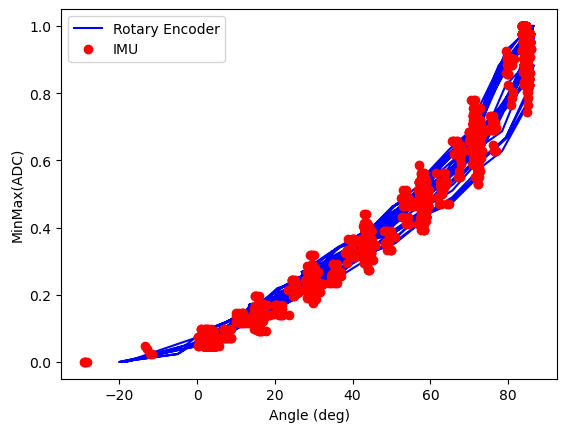

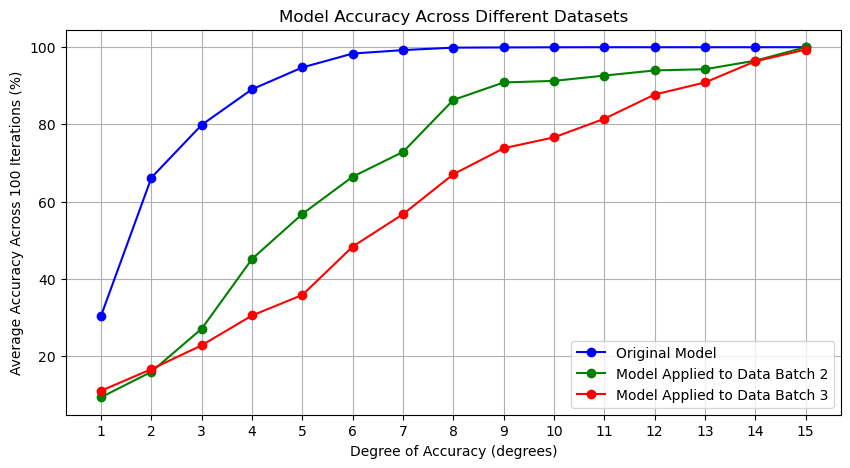

In [344]:
g = bender_class(data=pd.DataFrame())
path = "C:/Users/toppenheim/Desktop/UCSF/Preeya UCB/Glove 2024/bender_code/data/9_17_24/*.csv"
#path = "C:/Users/toppenheim/Desktop/UCSF/Preeya UCB/Strain-Sensor-/CSV Data/9_19_24_v1/single/*.csv"
g.read_data(path)
g.plot_data()
#g.quadratic_fit()

# Initialize the first dataset
g = bender_class(data=pd.DataFrame())
path_1 = "C:/Users/toppenheim/Desktop/UCSF/Preeya UCB/Glove 2024/bender_code/data/9_17_24/*.csv"
g.read_data(path_1)

# Initialize parameters for accuracy calculation
degree_of_accuracies = list(range(15, 0, -1))  # From 10 to 1
all_accuracies_first = []

# Calculate average accuracy for the first dataset using train_test
for degree in degree_of_accuracies:
    accuracies = []
    for _ in range(100):
        accuracy = g.train_test(deg_accuracy=degree)  # Use train_test for the first dataset
        accuracies.append(accuracy)
    all_accuracies_first.append(np.mean(accuracies))

# Create another bender_class instance for the second dataset
new_g = bender_class(data=pd.DataFrame())
path_2 = "C:/Users/toppenheim/Desktop/UCSF/Preeya UCB/Glove 2024/bender_code/data/9_19_24_v1/*.csv"
new_g.read_data(path_2)  # Read the second dataset

# Initialize accuracies for the second dataset
all_accuracies_second = []

# Calculate average accuracy for the second dataset using predict_new_data
for degree in degree_of_accuracies:
    accuracies = []
    for _ in range(100):
        accuracy, _ = g.predict_new_data(new_g, deg_accuracy=degree)  # Use predict_new_data
        accuracies.append(accuracy)
    all_accuracies_second.append(np.mean(accuracies))

# Create another bender_class instance for the third dataset
new_s = bender_class(data=pd.DataFrame())
path_3 = "C:/Users/toppenheim/Desktop/UCSF/Preeya UCB/Glove 2024/bender_code/data/9_19_24_v2/*.csv"
new_s.read_data(path_3)  # Read the third dataset

# Initialize accuracies for the third dataset
all_accuracies_third = []

# Calculate average accuracy for the third dataset using predict_new_data
for degree in degree_of_accuracies:
    accuracies = []
    for _ in range(100):
        accuracy, _ = g.predict_new_data(new_s, deg_accuracy=degree)  # Use predict_new_data
        accuracies.append(accuracy)
    all_accuracies_third.append(np.mean(accuracies))

# Plot all accuracies on the same plot
plt.figure(figsize=(10, 5))
plt.plot(degree_of_accuracies, all_accuracies_first, marker='o', label='Original Model', color='blue')
plt.plot(degree_of_accuracies, all_accuracies_second, marker='o', label='Model Applied to Data Batch 2', color='green')
plt.plot(degree_of_accuracies, all_accuracies_third, marker='o', label='Model Applied to Data Batch 3', color='red')

# Customize plot
plt.title('Model Accuracy Across Different Datasets')
plt.xlabel('Degree of Accuracy (degrees)')
plt.ylabel('Average Accuracy Across 100 Iterations (%)')
plt.xticks(degree_of_accuracies)  # Set x-ticks to correspond to degrees
plt.legend()  # Add legend to differentiate datasets
plt.grid()
plt.show()

# Model Fitting

The following block of code creates an object g that reads four sets of CSV files (without reapplication), constructs a pandas DataFrame, and fits a second-order polynomial model using 80% of the data for training and 20% for testing (as defined in the train_test class method). This data split is performed randomly. After fitting the model, the code plots the model's accuracy over 100 iterations.

Subsequently, the fitted model is used to assess the accuracy of two additional sets of tests, where reapplication occurred before each block of tests. 

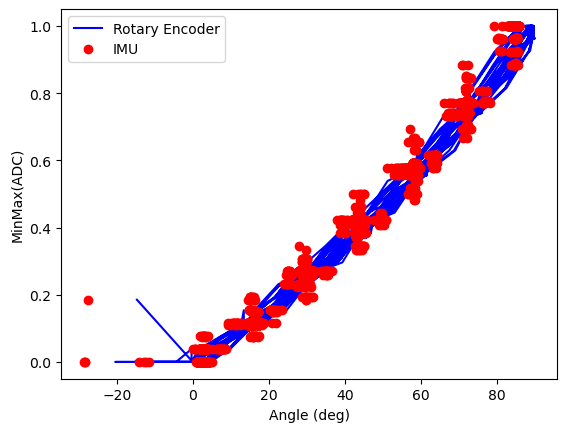

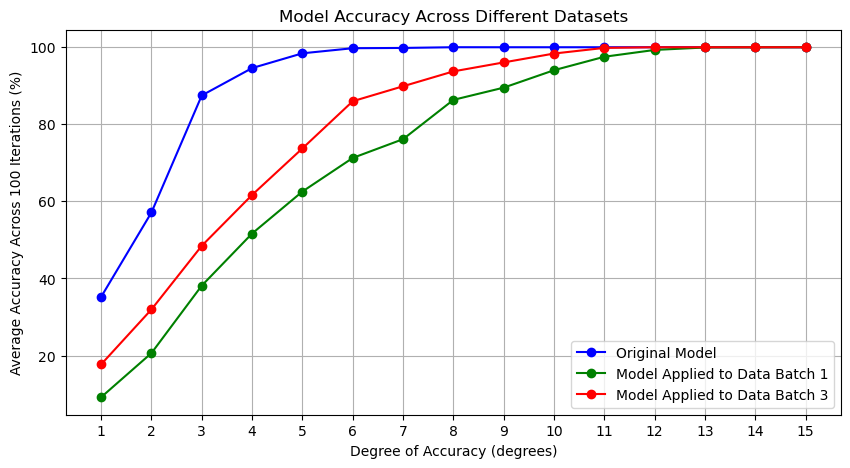

In [345]:
g = bender_class(data=pd.DataFrame())
path = "C:/Users/toppenheim/Desktop/UCSF/Preeya UCB/Glove 2024/bender_code/data/9_19_24_v1/*.csv"
#path = "C:/Users/toppenheim/Desktop/UCSF/Preeya UCB/Strain-Sensor-/CSV Data/9_19_24_v1/single/*.csv"
g.read_data(path)
g.plot_data()
#g.quadratic_fit()

# Initialize the first dataset
g = bender_class(data=pd.DataFrame())
path_1 = "C:/Users/toppenheim/Desktop/UCSF/Preeya UCB/Glove 2024/bender_code/data/9_19_24_v1/*.csv"
g.read_data(path_1)

# Initialize parameters for accuracy calculation
degree_of_accuracies = list(range(15, 0, -1))  # From 10 to 1
all_accuracies_first = []

# Calculate average accuracy for the first dataset using train_test
for degree in degree_of_accuracies:
    accuracies = []
    for _ in range(100):
        accuracy = g.train_test(deg_accuracy=degree)  # Use train_test for the first dataset
        accuracies.append(accuracy)
    all_accuracies_first.append(np.mean(accuracies))

# Create another bender_class instance for the second dataset
new_g = bender_class(data=pd.DataFrame())
path_2 = "C:/Users/toppenheim/Desktop/UCSF/Preeya UCB/Glove 2024/bender_code/data/9_17_24/*.csv"
new_g.read_data(path_2)  # Read the second dataset

# Initialize accuracies for the second dataset
all_accuracies_second = []

# Calculate average accuracy for the second dataset using predict_new_data
for degree in degree_of_accuracies:
    accuracies = []
    for _ in range(100):
        accuracy, _ = g.predict_new_data(new_g, deg_accuracy=degree)  # Use predict_new_data
        accuracies.append(accuracy)
    all_accuracies_second.append(np.mean(accuracies))

# Create another bender_class instance for the third dataset
new_s = bender_class(data=pd.DataFrame())
path_3 = "C:/Users/toppenheim/Desktop/UCSF/Preeya UCB/Glove 2024/bender_code/data/9_19_24_v2/*.csv"
new_s.read_data(path_3)  # Read the third dataset

# Initialize accuracies for the third dataset
all_accuracies_third = []

# Calculate average accuracy for the third dataset using predict_new_data
for degree in degree_of_accuracies:
    accuracies = []
    for _ in range(100):
        accuracy, _ = g.predict_new_data(new_s, deg_accuracy=degree)  # Use predict_new_data
        accuracies.append(accuracy)
    all_accuracies_third.append(np.mean(accuracies))

# Plot all accuracies on the same plot
plt.figure(figsize=(10, 5))
plt.plot(degree_of_accuracies, all_accuracies_first, marker='o', label='Original Model', color='blue')
plt.plot(degree_of_accuracies, all_accuracies_second, marker='o', label='Model Applied to Data Batch 1', color='green')
plt.plot(degree_of_accuracies, all_accuracies_third, marker='o', label='Model Applied to Data Batch 3', color='red')

# Customize plot
plt.title('Model Accuracy Across Different Datasets')
plt.xlabel('Degree of Accuracy (degrees)')
plt.ylabel('Average Accuracy Across 100 Iterations (%)')
plt.xticks(degree_of_accuracies)  # Set x-ticks to correspond to degrees
plt.legend()  # Add legend to differentiate datasets
plt.grid()
plt.show()

# Model Fitting

The following block of code creates an object g that reads four sets of CSV files (without reapplication), constructs a pandas DataFrame, and fits a second-order polynomial model using 80% of the data for training and 20% for testing (as defined in the train_test class method). This data split is performed randomly. After fitting the model, the code plots the model's accuracy over 100 iterations.

Subsequently, the fitted model is used to assess the accuracy of two additional sets of tests, where reapplication occurred before each block of tests. 

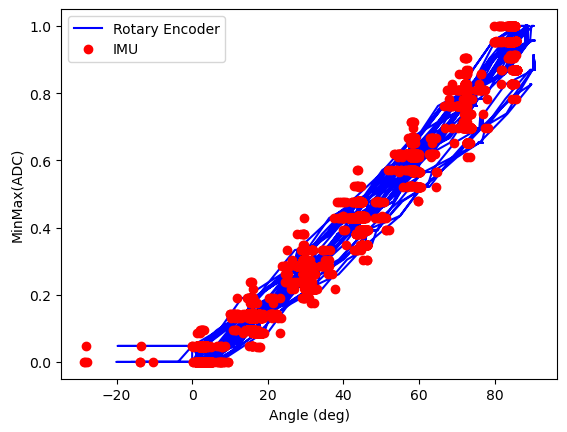

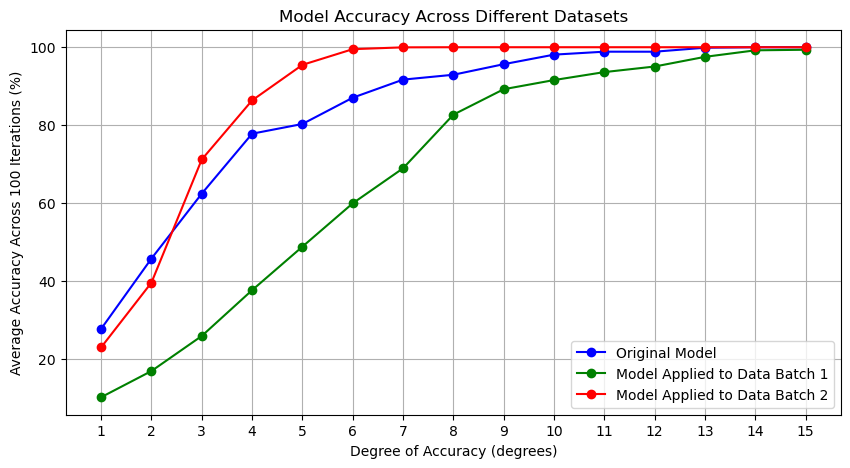

In [360]:
g = bender_class(data=pd.DataFrame())
path = "C:/Users/toppenheim/Desktop/UCSF/Preeya UCB/Glove 2024/bender_code/data/9_19_24_v2/*.csv"
#path = "C:/Users/toppenheim/Desktop/UCSF/Preeya UCB/Strain-Sensor-/CSV Data/9_19_24_v1/single/*.csv"
g.read_data(path)
g.plot_data()
#g.quadratic_fit()

# Initialize the first dataset
g = bender_class(data=pd.DataFrame())
path_1 = "C:/Users/toppenheim/Desktop/UCSF/Preeya UCB/Glove 2024/bender_code/data/9_19_24_v2/*.csv"
g.read_data(path_1)

# Initialize parameters for accuracy calculation
degree_of_accuracies = list(range(15, 0, -1))  # From 10 to 1
all_accuracies_first = []

# Calculate average accuracy for the first dataset using train_test
for degree in degree_of_accuracies:
    accuracies = []
    for _ in range(100):
        accuracy = g.train_test(deg_accuracy=degree)  # Use train_test for the first dataset
        accuracies.append(accuracy)
    all_accuracies_first.append(np.mean(accuracies))

# Create another bender_class instance for the second dataset
new_g = bender_class(data=pd.DataFrame())
path_2 = "C:/Users/toppenheim/Desktop/UCSF/Preeya UCB/Glove 2024/bender_code/data/9_17_24/*.csv"
new_g.read_data(path_2)  # Read the second dataset

# Initialize accuracies for the second dataset
all_accuracies_second = []

# Calculate average accuracy for the second dataset using predict_new_data
for degree in degree_of_accuracies:
    accuracies = []
    for _ in range(100):
        accuracy, _ = g.predict_new_data(new_g, deg_accuracy=degree)  # Use predict_new_data
        accuracies.append(accuracy)
    all_accuracies_second.append(np.mean(accuracies))

# Create another bender_class instance for the third dataset
new_s = bender_class(data=pd.DataFrame())
path_3 = "C:/Users/toppenheim/Desktop/UCSF/Preeya UCB/Glove 2024/bender_code/data/9_19_24_v1/*.csv"
new_s.read_data(path_3)  # Read the third dataset

# Initialize accuracies for the third dataset
all_accuracies_third = []

# Calculate average accuracy for the third dataset using predict_new_data
for degree in degree_of_accuracies:
    accuracies = []
    for _ in range(100):
        accuracy, _ = g.predict_new_data(new_s, deg_accuracy=degree)  # Use predict_new_data
        accuracies.append(accuracy)
    all_accuracies_third.append(np.mean(accuracies))

# Plot all accuracies on the same plot
plt.figure(figsize=(10, 5))
plt.plot(degree_of_accuracies, all_accuracies_first, marker='o', label='Original Model', color='blue')
plt.plot(degree_of_accuracies, all_accuracies_second, marker='o', label='Model Applied to Data Batch 1', color='green')
plt.plot(degree_of_accuracies, all_accuracies_third, marker='o', label='Model Applied to Data Batch 2', color='red')

# Customize plot
plt.title('Model Accuracy Across Different Datasets')
plt.xlabel('Degree of Accuracy (degrees)')
plt.ylabel('Average Accuracy Across 100 Iterations (%)')
plt.xticks(degree_of_accuracies)  # Set x-ticks to correspond to degrees
plt.legend()  # Add legend to differentiate datasets
plt.grid()
plt.show()

#  Using the Wheatstone Bridge Circuit and 24-bit ADC

x64 gain and reference voltage of 2.4V
18 mV across A+ and A- measured with handheld multimeter

R1 = 101 ohms
R2 = var resistor 0 - 1 kohm (balanced to make Vout as close to 0 as possible)
Rx = 100 ohm + strain guage (0.8 ohms)
R3 = 100 ohm


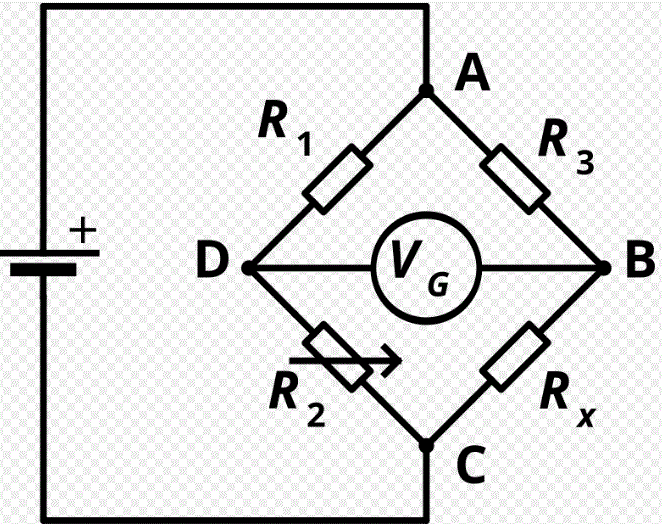

Found 1 CSV files.
96.60493827160494


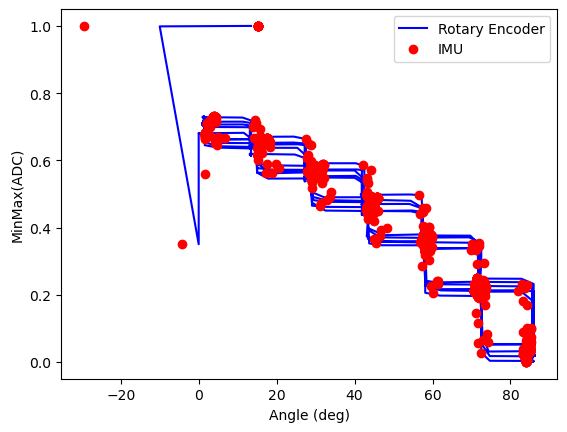

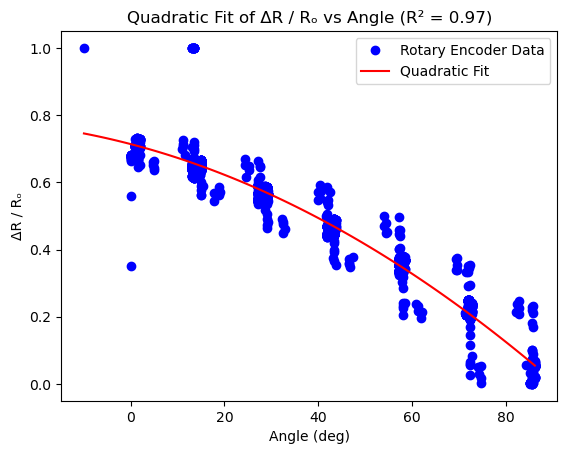

In [347]:
import numpy as np
import matplotlib.pyplot as plt  # To visualize

g = bender_class(data=pd.DataFrame())
#path contains 5 csv files
path = "C:/Users/toppenheim/Desktop/UCSF/Preeya UCB/Glove 2024/bender_code/data/10_1_24/v6/*.csv"
#PLEASE NOT THERE WERE OUTLIER DATA POINTS AROUND 0 delta R over Ro WHICH WERE REMOVED!
g.read_data_2(path)

# Perform quadratic fit where 80% train/ 20% test, and determine accuracy to +/- 10 deg
accuracy = g.train_test(deg_accuracy=10)
print(accuracy)

# Plot the data with fitted results
g.plot_data()
g.quadratic_fit()

#  Using the Wheatstone Bridge Circuit and 24-bit ADC

x128 gain and reference voltage of 2.7V
5.8 mV across A+ and A- measured with handheld multimeter

Found 1 CSV files.
96.3020030816641


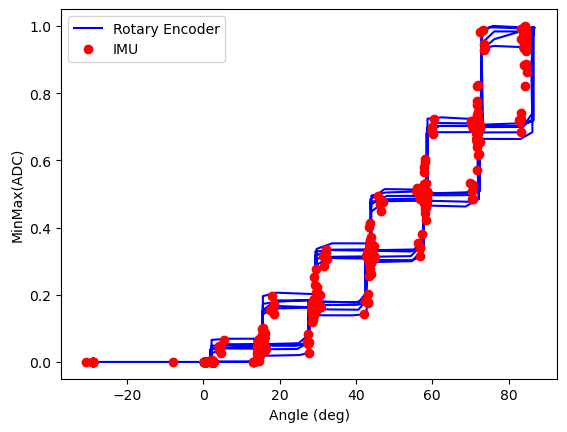

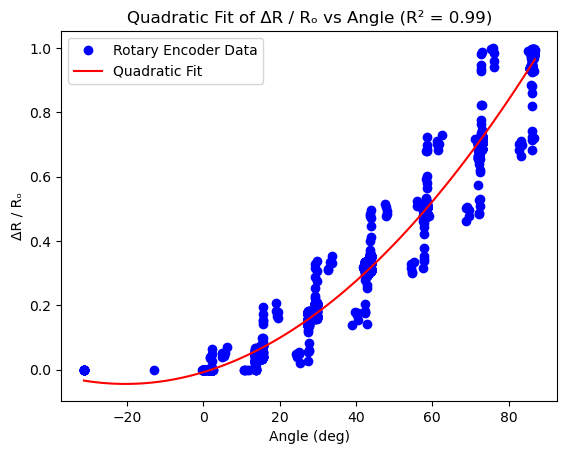

In [348]:
import numpy as np
import matplotlib.pyplot as plt  # To visualize

g = bender_class(data=pd.DataFrame())
#path contains 5 csv files
path = "C:/Users/toppenheim/Desktop/UCSF/Preeya UCB/Glove 2024/bender_code/data/10_2_24/*.csv"
#PLEASE NOT THERE WERE OUTLIER DATA POINTS AROUND 0 delta R over Ro WHICH WERE REMOVED!
g.read_data_2(path)

# Perform quadratic fit where 80% train/ 20% test, and determine accuracy to +/- 10 deg
accuracy = g.train_test(deg_accuracy=10)
print(accuracy)

# Plot the data with fitted results
g.plot_data()
g.quadratic_fit()

#  First Good Test!  Using the Wheatstone Bridge Circuit and 24-bit ADC 

x32 or x128 gain and reference voltage of 2.7V (check excel lab notebook)
5.8 mV across A+ and A- measured with handheld multimeter

increased length delay between servo rotate and data collection from 50 ms to 1 sec

Found 1 CSV files.
100.0


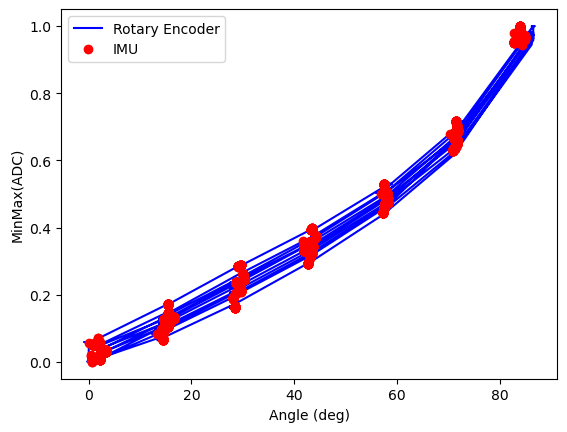

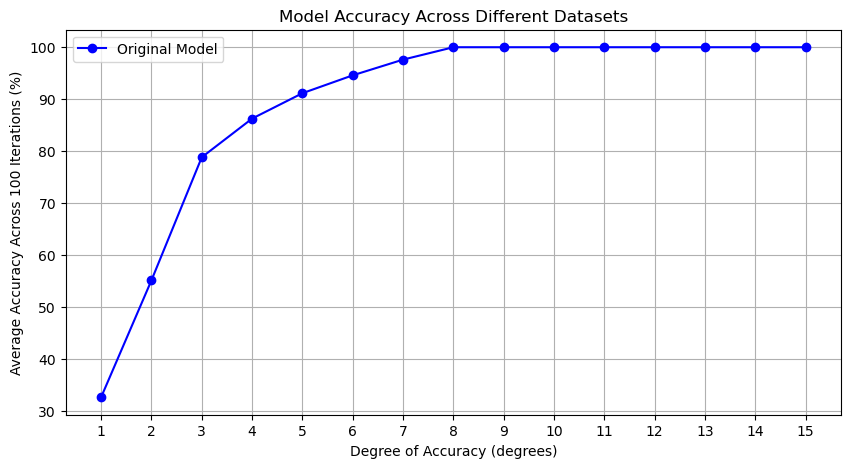

In [355]:
import numpy as np
import matplotlib.pyplot as plt  # To visualize

g = bender_class(data=pd.DataFrame())
#path contains 4 csv files
path = "C:/Users/toppenheim/Desktop/UCSF/Preeya UCB/Strain-Sensor-/CSV Data/10_14_2024/v2/single data set/*.csv"
g.read_data_2(path)

# Perform quadratic fit where 80% train/ 20% test, and determine accuracy to +/- 10 deg
accuracy = g.train_test(deg_accuracy=10)
print(accuracy)

# Plot the data with fitted results
g.plot_data()

# Initialize the first dataset
g = bender_class(data=pd.DataFrame())
path_1 = path
g.read_data(path_1)

# Initialize parameters for accuracy calculation
degree_of_accuracies = list(range(15, 0, -1))  # From 10 to 1
all_accuracies_first = []

# Calculate average accuracy for the first dataset using train_test
for degree in degree_of_accuracies:
    accuracies = []
    for _ in range(100):
        accuracy = g.train_test(deg_accuracy=degree)  # Use train_test for the first dataset
        accuracies.append(accuracy)
    all_accuracies_first.append(np.mean(accuracies))
    
# Plot all accuracies on the same plot
plt.figure(figsize=(10, 5))
plt.plot(degree_of_accuracies, all_accuracies_first, marker='o', label='Original Model', color='blue')

# Customize plot
plt.title('Model Accuracy Across Different Datasets')
plt.xlabel('Degree of Accuracy (degrees)')
plt.ylabel('Average Accuracy Across 100 Iterations (%)')
plt.xticks(degree_of_accuracies)  # Set x-ticks to correspond to degrees
plt.legend()  # Add legend to differentiate datasets
plt.grid()



#  8 Tests no Reapplication:  Slipping?   Using the Wheatstone Bridge Circuit and 24-bit ADC 

x32 or x128 gain and reference voltage of 2.7V (check excel lab notebook)
5.8 mV across A+ and A- measured with handheld multimeter

increased length delay between servo rotate and data collection from 50 ms to 1 sec

Found 8 CSV files.
96.51050703682283


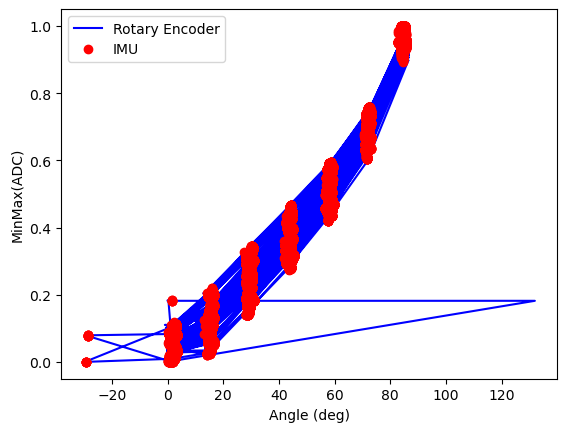

Found 8 CSV files.


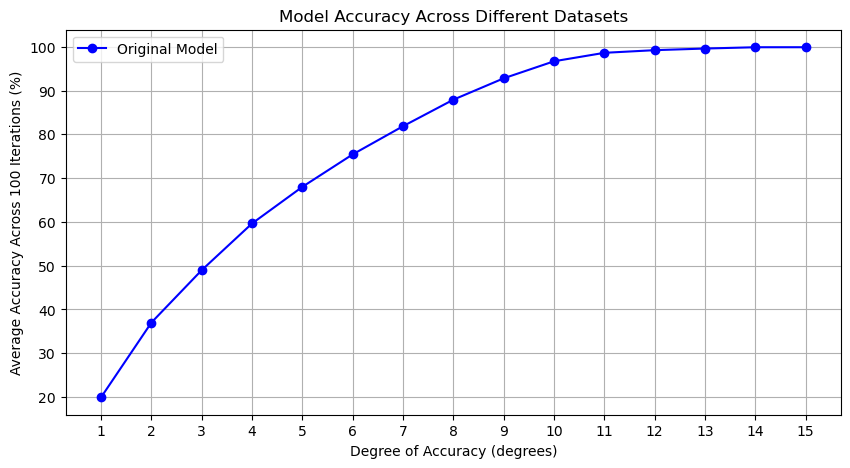

In [359]:
import numpy as np
import matplotlib.pyplot as plt  # To visualize

g = bender_class(data=pd.DataFrame())
#path contains 4 csv files
path = "C:/Users/toppenheim/Desktop/UCSF/Preeya UCB/Strain-Sensor-/CSV Data/10_14_2024/v2/*.csv"
g.read_data_2(path)

# Drop NaN values from g.data after reading data
g.data = g.data.dropna()

# Perform quadratic fit where 80% train/ 20% test, and determine accuracy to +/- 10 deg
accuracy = g.train_test(deg_accuracy=10)
print(accuracy)

# Plot the data with fitted results
g.plot_data()

# Initialize the first dataset
g = bender_class(data=pd.DataFrame())
path_1 = "C:/Users/toppenheim/Desktop/UCSF/Preeya UCB/Strain-Sensor-/CSV Data/10_14_2024/v2/*.csv"
g.read_data_2(path_1)

# Drop NaN values from g.data after reading data
g.data = g.data.dropna()

# Initialize parameters for accuracy calculation
degree_of_accuracies = list(range(15, 0, -1))  # From 10 to 1
all_accuracies_first = []

# Calculate average accuracy for the first dataset using train_test
for degree in degree_of_accuracies:
    accuracies = []
    for _ in range(100):
        accuracy = g.train_test(deg_accuracy=degree)  # Use train_test for the first dataset
        accuracies.append(accuracy)
    all_accuracies_first.append(np.mean(accuracies))
    
# Plot all accuracies on the same plot
plt.figure(figsize=(10, 5))
plt.plot(degree_of_accuracies, all_accuracies_first, marker='o', label='Original Model', color='blue')

# Customize plot
plt.title('Model Accuracy Across Different Datasets')
plt.xlabel('Degree of Accuracy (degrees)')
plt.ylabel('Average Accuracy Across 100 Iterations (%)')
plt.xticks(degree_of_accuracies)  # Set x-ticks to correspond to degrees
plt.legend()  # Add legend to differentiate datasets
plt.grid()



#  1 Test Reapplication:    Using the Wheatstone Bridge Circuit and 24-bit ADC 

x32 or x128 gain and reference voltage of 2.7V (check excel lab notebook)
5.8 mV across A+ and A- measured with handheld multimeter

increased length delay between servo rotate and data collection from 50 ms to 1 sec

Found 1 CSV files.


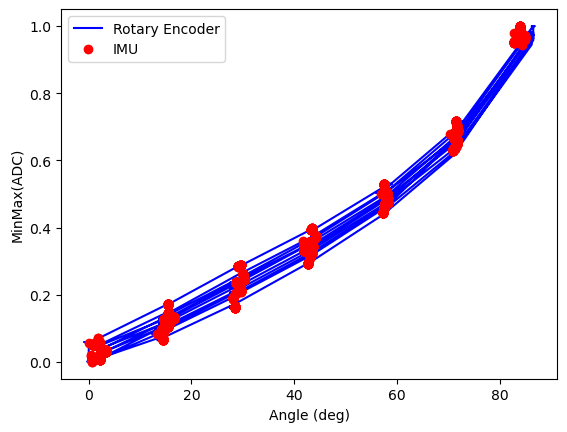

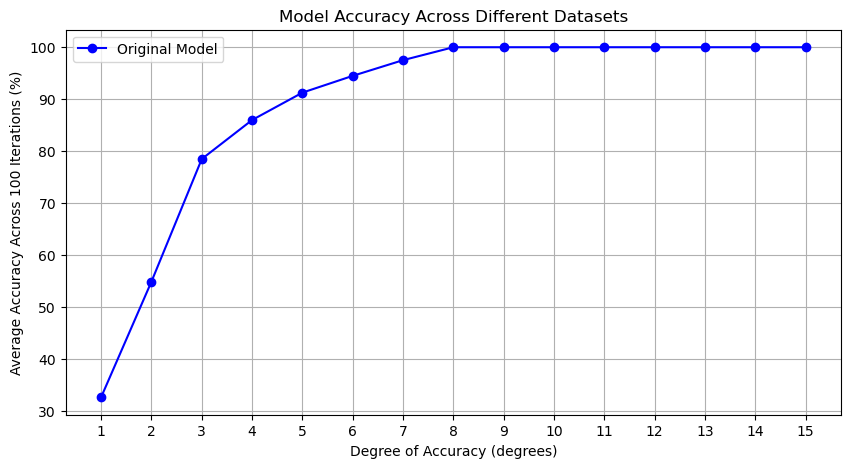

In [353]:
import numpy as np
import matplotlib.pyplot as plt  # To visualize

g = bender_class(data=pd.DataFrame())
#path contains 4 csv files
path = "C:/Users/toppenheim/Desktop/UCSF/Preeya UCB/Strain-Sensor-/CSV Data/10_14_2024/v2/single data set/*.csv"
g.read_data_2(path)


# Perform quadratic fit where 80% train/ 20% test, and determine accuracy to +/- 10 deg
accuracy = g.train_test(deg_accuracy=10)
#print(accuracy)

# Plot the data with fitted results
g.plot_data()

# Initialize the first dataset
g = bender_class(data=pd.DataFrame())
path_1 = path
g.read_data(path_1)



# Initialize parameters for accuracy calculation
degree_of_accuracies = list(range(15, 0, -1))  # From 10 to 1
all_accuracies_first = []

# Calculate average accuracy for the first dataset using train_test
for degree in degree_of_accuracies:
    accuracies = []
    for _ in range(100):
        accuracy = g.train_test(deg_accuracy=degree)  # Use train_test for the first dataset
        accuracies.append(accuracy)
    all_accuracies_first.append(np.mean(accuracies))
    
# Plot all accuracies on the same plot
plt.figure(figsize=(10, 5))
plt.plot(degree_of_accuracies, all_accuracies_first, marker='o', label='Original Model', color='blue')

# Customize plot
plt.title('Model Accuracy Across Different Datasets')
plt.xlabel('Degree of Accuracy (degrees)')
plt.ylabel('Average Accuracy Across 100 Iterations (%)')
plt.xticks(degree_of_accuracies)  # Set x-ticks to correspond to degrees
plt.legend()  # Add legend to differentiate datasets
plt.grid()



#  1 Test and Last with Reapplication:    Using the Wheatstone Bridge Circuit and 24-bit ADC 

x32 or x128 gain and reference voltage of 2.7V (check excel lab notebook)
5.8 mV across A+ and A- measured with handheld multimeter

increased length delay between servo rotate and data collection from 50 ms to 1 sec

Found 2 CSV files.
100.0


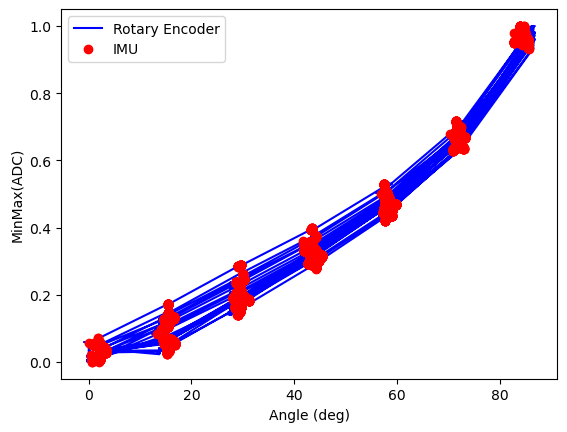

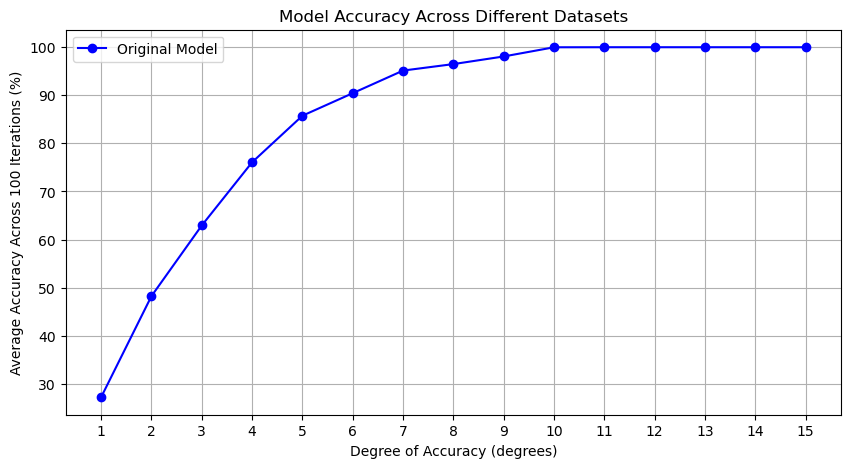

In [356]:
import numpy as np
import matplotlib.pyplot as plt  # To visualize

g = bender_class(data=pd.DataFrame())
#path contains 4 csv files
path = "C:/Users/toppenheim/Desktop/UCSF/Preeya UCB/Strain-Sensor-/CSV Data/10_14_2024/v2/data no slipping/*.csv"
g.read_data_2(path)


# Perform quadratic fit where 80% train/ 20% test, and determine accuracy to +/- 10 deg
accuracy = g.train_test(deg_accuracy=10)
print(accuracy)

# Plot the data with fitted results
g.plot_data()



# Initialize parameters for accuracy calculation
degree_of_accuracies = list(range(15, 0, -1))  # From 10 to 1
all_accuracies_first = []

# Calculate average accuracy for the first dataset using train_test
for degree in degree_of_accuracies:
    accuracies = []
    for _ in range(100):
        accuracy = g.train_test(deg_accuracy=degree)  # Use train_test for the first dataset
        accuracies.append(accuracy)
    all_accuracies_first.append(np.mean(accuracies))
    
# Plot all accuracies on the same plot
plt.figure(figsize=(10, 5))
plt.plot(degree_of_accuracies, all_accuracies_first, marker='o', label='Original Model', color='blue')

# Customize plot
plt.title('Model Accuracy Across Different Datasets')
plt.xlabel('Degree of Accuracy (degrees)')
plt.ylabel('Average Accuracy Across 100 Iterations (%)')
plt.xticks(degree_of_accuracies)  # Set x-ticks to correspond to degrees
plt.legend()  # Add legend to differentiate datasets
plt.grid()

